# Solving nonogram puzzles in CPMpy

The nonogram puzzle consists of coloring a set of squares.
The nonogram puzzle board consists of a recangle of squares.
The goal of the puzzle is to fill in the squares according to some constraints such that a picture is displayed.
For each row in the grid, a sequence of "colored squares" is indicated using a tuple of integers.
Each integer represents the length of a "colored group". 
Between each colored group one or more uncolored squares should be present in the solution of the problem.

For example: when playing on a 10x10 board, the tuple (2,1,4) for a given row has the following solution: BBWBWWBBBB but also BBWWBWBBBB.

The same rules apply to each column. The solution of a nonogram is unique.

This notebook requires you to install _pillow_ and _matplotlib_

In [1]:
! pip install pillow matplotlib --quiet

## Generating nonogram constraints from an image

We first have some code that takes an image (matrix of pixels) as input and generates the corresponding nonogram row and column constraints.

In [2]:
import urllib
from PIL import Image
import requests
import numpy as np
from io import BytesIO


def picture_to_nonogram_constraints(url):
    r = requests.get(url, stream=True)
    img = np.array(Image.open(BytesIO(r.content)))

    # convert to black/white: binary
    img = img.mean(axis=2)
    thresh = (img.max() - img.min()) / 2
    img[img < thresh] = 0
    img[img >= thresh] = 1

    # convert image to nonogram clues
    row_rules = []
    for row in img:
        idx = np.concatenate(([0],np.flatnonzero(row[:-1]!=row[1:])+1,[row.size]))
        out = zip(row[idx[:-1]],np.diff(idx))
        row_rules.append([nb for (val, nb) in out if val == 1])

    col_rules = []
    for col in img.T:
        idx = np.concatenate(([0],np.flatnonzero(col[:-1]!=col[1:])+1,[col.size]))
        out = zip(col[idx[:-1]],np.diff(idx))
        col_rules.append([nb for (val, nb) in out if val == 1])
    
    return row_rules, col_rules

Show the nonogram constraints for the image

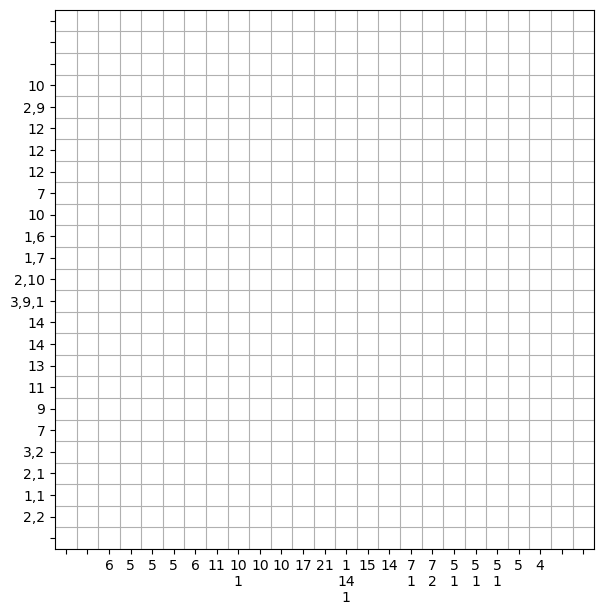

In [3]:
# get picture from web
# for fast runtime, limit to size +-200x200 pixels
url = "https://github.com/CPMpy/cpmpy/raw/hve-examples/examples/assets/t-rex.png" # T-rex
# url = "https://pbs.twimg.com/profile_images/711593363624095747/lJV3XX-H_400x400.jpg" # Alan Turing

row_rules, col_rules = picture_to_nonogram_constraints(url)

# visualise the constraints over the grid
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow([[0 for x in range(len(col_rules))] for y in range(len(row_rules))],cmap="binary")
ax.set_xticks(range(len(col_rules)), ["\n".join([str(i) for i in r]) for r in col_rules])
ax.set_yticks(range(len(row_rules)), [",".join([str(i) for i in r]) for r in row_rules])
ax.grid(which='minor')
ax.minorticks_on()
ax.tick_params(which='minor', bottom=False, left=False)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2)) # we show minor gridlines between the constraints, so that they allign with the blocks to be colored in.

# Solving it with constraint programming

To solve it with a CP solver, we can for example represent each row (resp column) as an automaton.
For example, the rule (1,2) for a board with dimension 5 corresponds to the following automaton:
![automaton](assets/automaton.png)

CPMpy itself does not have an 'automaton' global constraint. However, some solvers do. OrTools is such a solver, which accepts a specific input (TODO: describe what its 4 expected parameters are)

In this notebook, we demonstrate that you can use such solver specific constraints conveniently thourgh the `DirectConstraint` class.

First, we define a function to compute the state transitions:

In [4]:
from cpmpy import *

def transition_function(pattern):
    """
        Pattern is a vector containing the lengths of blocks with value 1
        Returns transition function with format (start_state, char, end_state)
    """
    func = []
    n_states = 0
    for block_length in pattern:
        if block_length == 0:
            continue
        # can stay in same state for emtpy cell
        func += [(n_states, 0, n_states)]
        # group contains exact number of filled cells
        for _ in range(block_length):
            func += [(n_states, 1, n_states+1)]
            n_states += 1
        # go to next subgroup after group is finished
        func += [(n_states, 0, n_states+1)]
        n_states += 1

    func += [(n_states, 0, n_states)]
        # line can end empty or filled
    return func, [n_states-1,n_states]

def nonogram_rule_to_ort_automaton(lst, pattern):
    automaton_func, final_states = transition_function(pattern)
    
    # OR-tools version of the 'Regular' constraint
    return DirectConstraint("AddAutomaton", (lst, 0, final_states, automaton_func),
                            novar=[1,2,3])  # only 'lst' contains variables, needs reverse mapping

Now the actual nonogram constraint model, which includes the above on-the-fly generated DirectConstraints

In [5]:
def nonogram(row_rules, col_rules, **kwargs):

    model = Model()

    n_rows, n_cols = len(row_rules), len(col_rules)
    board = intvar(0,1,shape=(n_rows,n_cols), name="board")

    # add row constraints
    for r, pattern in enumerate(row_rules):
        model += nonogram_rule_to_ort_automaton(board[r], pattern)

    # add column constraints
    for c, pattern in enumerate(col_rules):
        model += nonogram_rule_to_ort_automaton(board[:,c], pattern)

    return model, (board,)

In [6]:
model, (board,) = nonogram(row_rules, col_rules)

# Depending on the size of the image, solving may take a long time
assert model.solve(solver="ortools")

C:\Users\wout\AppData\Local\Temp\ipykernel_18252\34177285.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


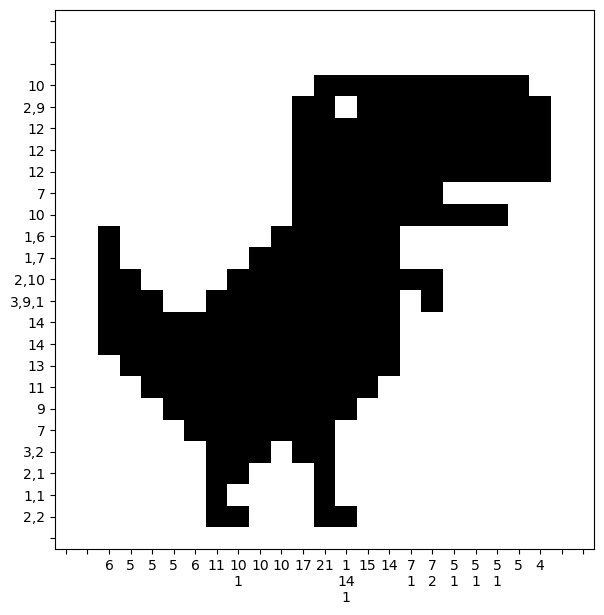

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

ax.imshow(board.value(),cmap="binary")

# show nonogram rules? (only for small images)
ax.set_xticks(range(len(col_rules)), ["\n".join([str(i) for i in r]) for r in col_rules])
ax.set_yticks(range(len(row_rules)), [",".join([str(i) for i in r]) for r in row_rules])

fig.show()

In [8]:
print("Repeating just the column constraints for you to crosscheck:")
for cr in col_rules:
    print("\t",cr, end="")

Repeating just the column constraints for you to crosscheck:
	 []	 []	 [6]	 [5]	 [5]	 [5]	 [6]	 [11]	 [10, 1]	 [10]	 [10]	 [17]	 [21]	 [1, 14, 1]	 [15]	 [14]	 [7, 1]	 [7, 2]	 [5, 1]	 [5, 1]	 [5, 1]	 [5]	 [4]	 []	 []

In [9]:
# and that there is only 1 solution:
model.solveAll()

1